[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=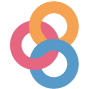)](https://mybinder.org/v2/gh/pangeo-forge/pangeo-forge-bakery-images/binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fpangeo-forge%252Fpangeo-forge-recipes%26urlpath%3Dtree%252Fpangeo-forge-recipes%252F%252Fdocs%252Ftutorials%252Fxarray_zarr%252Fterraclimate.ipynb%26branch%3Dmaster)

# Complex NetCDF to Zarr Recipe: TerraClimate 

## About the Dataset

From http://www.climatologylab.org/terraclimate.html:

> TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019. We plan to update these data periodically (annually).

## What makes it tricky

This is an advanced example that illustrates the following concepts
- _Multiple variables in different files_: There is one file per year for a dozen different variables.
- _Complex Preprocessing_: We want to apply different preprocessing depending on the variable. This example shows how.
- _Inconsistent size of data in input files_: This means we have to scan each input file and cache its metadata before we can start writing the target.

This recipe requires a new storage target, a `metadata_cache`. In this example, this is just another directory. You could hypothetically use a database or other key/value store for this.

In [ ]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
import xarray as xr

## Define Filename Pattern 

To keep this example smaller, we just use two years instead of the whole record.

In [ ]:
target_chunks = {"lat": 1024, "lon": 1024, "time": 12}
# only do two years to keep the example small; it's still big!
years = list(range(1958, 1960))
variables = [
    "aet",
    "def",
    "pet",
    "ppt",
    "q",
    "soil",
    "srad",
    "swe",
    "tmax",
    "tmin",
    "vap",
    "ws",
    "vpd",
    "PDSI",
]

def make_filename(variable, time):
    return f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_{variable}_{time}.nc"

pattern = FilePattern(
    make_filename,
    ConcatDim(name="time", keys=years),
    MergeDim(name="variable", keys=variables)
)
pattern

Check out the pattern:

In [ ]:
for key, filename in pattern.items():
    break
key, filename

## Define Preprocessing Functions

These functions apply masks for each variable to remove invalid data.

In [ ]:
rename_vars = {'PDSI': 'pdsi'}

mask_opts = {
    "PDSI": ("lt", 10),
    "aet": ("lt", 32767),
    "def": ("lt", 32767),
    "pet": ("lt", 32767),
    "ppt": ("lt", 32767),
    "ppt_station_influence": None,
    "q": ("lt", 2147483647),
    "soil": ("lt", 32767),
    "srad": ("lt", 32767),
    "swe": ("lt", 10000),
    "tmax": ("lt", 200),
    "tmax_station_influence": None,
    "tmin": ("lt", 200),
    "tmin_station_influence": None,
    "vap": ("lt", 300),
    "vap_station_influence": None,
    "vpd": ("lt", 300),
    "ws": ("lt", 200),
}

def apply_mask(key, da):
    """helper function to mask DataArrays based on a threshold value"""
    if mask_opts.get(key, None):
        op, val = mask_opts[key]
        if op == "lt":
            da = da.where(da < val)
        elif op == "neq":
            da = da.where(da != val)
    return da


def preproc(ds):
    """custom preprocessing function for terraclimate data"""
    
    rename = {}

    station_influence = ds.get("station_influence", None)

    if station_influence is not None:
        ds = ds.drop_vars("station_influence")

    var = list(ds.data_vars)[0]

    if var in rename_vars:
        rename[var] = rename_vars[var]

    if "day" in ds.coords:
        rename["day"] = "time"

    if station_influence is not None:
        ds[f"{var}_station_influence"] = station_influence

    with xr.set_options(keep_attrs=True):
        ds[var] = apply_mask(var, ds[var])

    if rename:
        ds = ds.rename(rename)
                
    return ds


## Define Recipe

We are now ready to define the recipe.
We also specify the desired chunks of the target dataset.

A key property of this recipe is `nitems_per_input=None`, which triggers caching of input metadata.

In [ ]:
chunks = {"lat": 1024, "lon": 1024, "time": 12}

recipe = XarrayZarrRecipe(
    file_pattern=pattern,
    target_chunks=target_chunks,
    process_chunk=preproc
)
recipe

## Define Storage Targets

Since we did not specify `nitems_per_file` in our `ConcatDim`, the recipe needs to cache input metadata.
So we need to suply a `metadata_cache` target.

In [ ]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget, MetadataTarget

fs_local = LocalFileSystem()

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

meta_dir = tempfile.TemporaryDirectory()
meta_store = MetadataTarget(fs_local, meta_dir.name)

recipe.target = target
recipe.input_cache = cache_target
recipe.metadata_cache = meta_store
recipe

## Execute with Prefect

This produces A LOT of output because we turn on logging.

In [ ]:
# logging will display some interesting information about our recipe during execution
import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger("pangeo_forge_recipes")
logger.setLevel(logging.INFO)

In [ ]:
flow = recipe.to_prefect()
flow.run()

## Check and Plot Target

In [ ]:
ds_target = xr.open_zarr(target.get_mapper(), consolidated=True)
ds_target

As an example calculation, we compute and plot the seasonal climatology of soil moisture.

In [ ]:
with xr.set_options(keep_attrs=True):
    soil_clim = ds_target.soil.groupby('time.season').mean('time').coarsen(lon=12, lat=12).mean()
soil_clim

In [ ]:
soil_clim.plot(col='season', col_wrap=2, robust=True, figsize=(18, 8))